In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
import libs.exploring as explore
import libs.visualising as visualize
import libs.cleansing as cleanse

# Explore data using PySpark

Packages I had to install:
    - pip install pyspark_dist_explore
    - pip install plotly
and then restart the Kernel.

In [2]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import,
                            index_col='code')

#### Find NaN columns

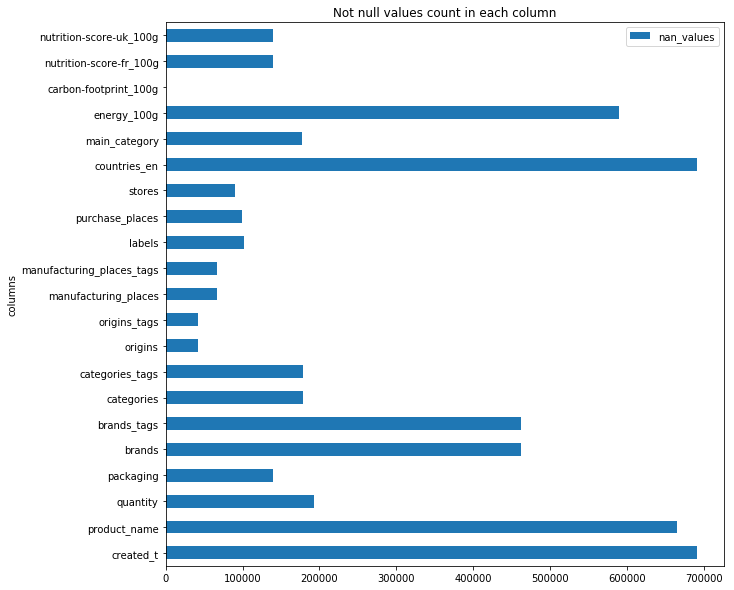

In [3]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
plt.title("Not null values count in each column")
plt.show()

This number is way too low. We need to find a way to deal with incomplete data or a way to complete it.

# Data cleansing
Guys, the country tags in this dataset are a mess. They differ in language, typesetting, everything. I am trying to clean them up, but I could not find an automated way to assign the correct country tags. 
This is why I've started a list with correct mappings in the countries_replacement.json file, which is still incomplete and I need your help to complete this list. Take a look at it, I think it is self-explaining.

### Unitize tags


In [4]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

In [5]:
food_facts_pd = food_facts_pd.fillna("")
food_facts_pd

,created_t,product_name,quantity,packaging,brands,brands_tags,categories,categories_tags,origins,origins_tags,...,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000274722,1514659309,Blanquette de Volaille et son Riz,,"carton,plastique",Comme J’aime,comme-j-aime,"Plats préparés,Meat-based products,Plats à bas...","en:meals,en:meat-based-products,en:meals-with-...",France,france,...,france,"Viande Française,Fabriqué en France",France,Comme J'aime,France,en:meals,450,,0,0
0000000290616,1484605978,Salade Cesar,0.980 kg,Frais,Kirkland Signature,kirkland-signature,Légumes-feuilles,"en:plant-based-foods-and-beverages,en:plant-ba...",Québec,quebec,...,brossard-quebec,,,Costco,Canada,en:plant-based-foods-and-beverages,1210,,6,6
0000000394710,1484497370,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,kirkland-signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past...",Québec,quebec,...,brossard-quebec,,Brossard Québec,Costco,Canada,en:sugary-snacks,1520,,,
0000001071894,1409411252,Flute,,"Paper,plastic film",Waitrose,waitrose,"Plant-based foods and beverages,Plant-based fo...","en:plant-based-foods-and-beverages,en:plant-ba...",France,france,...,united-kingdom,,"Brent,UK",Waitrose,United Kingdom,en:plant-based-foods-and-beverages,,,,
0000001938067,1484501528,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,kirkland-signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past...",Québec,quebec,...,brossard-quebec,,Brossard Québec,Costco,Canada,en:sugary-snacks,1090,,9,9
0000004302544,1488464896,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,kirkland-signature,Boulange,fr:boulange,Québec,quebec,...,"brossard,quebec",,"Brossard,Québec",Costco,Canada,fr:boulange,1160,,1,1
0000008237798,1491943307,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,kirkland-signature,Quiches lorraines,"en:meals,en:pizzas-pies-and-quiches,en:quiches...",Québec,quebec,...,"brossard,quebec",,"Brossard,Québec",Costco,Canada,en:meals,478,,2,2
0000008240095,1484342673,Pâté au poulet,1250 kg,Frais,Kirkland Signature,kirkland-signature,Poulets cuisinés,"en:meats,en:poultries,en:chickens,en:cooked-ch...",Québec,quebec,...,brossard-quebec,,Brossard Québec,Costco,Canada,en:meats,751,,,
0000010090206,1370977431,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,alice-delice,"Aliments et boissons à base de végétaux,Boisso...","en:plant-based-foods-and-beverages,en:beverage...",,,...,france,,"Lyon,France",Alice Délice,France,en:beverages,,,,


In [6]:
# Unitize countries names
with open('country_lookup.json', 'r') as json_data:
    countries_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(lambda x: [countries_lookup[z] for z in x.split(',')])


In [7]:
# Unitze labels
with open('taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels = food_facts_pd.labels.apply(lambda x: [labels_lookup[z] for z in x.split(',')])

In [8]:
# Store labels
with open('stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: [stores_lookup[z] for z in x.split(',')])

In [9]:
stores_lookup

{'LIDL': 'LIDL',
 'Lidl': 'LIDL',
 'lidl': 'LIDL',
 'Carrefour': 'Carrefour',
 'Carrefour Market': 'Carrefour',
 'Carrefour City': 'Carrefour',
 'Carrefour market': 'Carrefour',
 'ALDI': 'ALDI',
 'Aldi Nord': 'ALDI',
 'Aldi': 'ALDI',
 'Kaufland': 'Kaufland',
 'EDEKA': 'Edeka',
 'Edeka': 'Edeka',
 'Coop': 'Coop',
 'Coop Konsum': 'Coop',
 'Biocoop': 'Coop',
 'Walmart': 'Walmart',
 'walmart': 'Walmart',
 'WALMART': 'Walmart',
 'Rewe': 'Rewe',
 'REWE': 'Rewe'}

# Visualize data

In [10]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==1: # skip cell
    products = food_facts_pd

    products.to_pickle("./data/products_pd.pickle")
    


TypeError: 300.0 is not a string

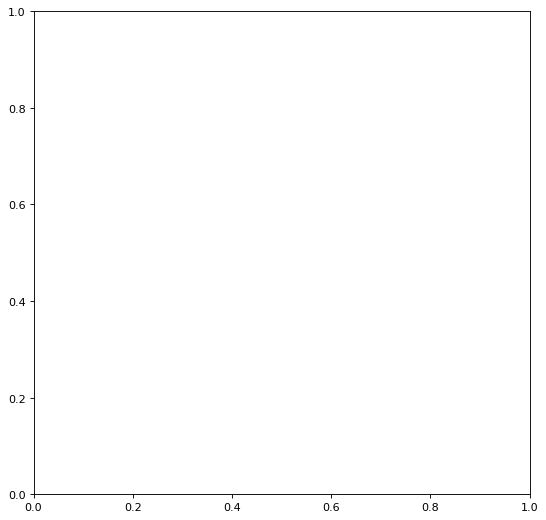

In [11]:
visualize.plot_cluster_by_tags(df=food_facts_pd.dropna(subset=['labels']),
                                 plot2D_features = ["carbon-footprint_100g", "energy_100g"],
                                 cluster="labels")

### Plot distribution of stores where items were bought

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Plot distribution of availability of products in countries

In [ ]:
# Find all distinct countries
countries_set = set()
for index, row in food_facts_pd.iterrows():
    for country in row.countries_en:
        countries_set.add(country)

# Count the number of time each country appear in the dataframe
country_count = dict()
for country in list(countries_set):
    country_count[country] = food_facts_pd.countries_en.apply({country}.issubset).sum()

In [ ]:
country_count_pd = pd.DataFrame(list(country_count.items()), columns=['Country', 'Value'])
country_count_pd['Country'] = country_count_pd['Country'].str.upper()
country_count_pd

In [ ]:
import folium

## Country coordinates for plotting
country_geo = './data/world-countries.json'

map = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
map.choropleth(geo_data=country_geo,
               data=country_count_pd,
               columns=['Country', 'Value'],
               fill_color='YlGnBu', 
               key_on='feature.id',
               fill_opacity=0.7, 
               line_opacity=0.2,
               )
map

### Plot carbon foot-print histogram over calories

In [ ]:
fig, ax = plt.subplots()

food_facts_pd['energy_100g'] = food_facts_pd['energy_100g'].astype('float')
food_facts_pd['carbon-footprint_100g'] = food_facts_pd['carbon-footprint_100g'].astype('float')

food_facts_pd.plot.scatter(x='energy_100g', 
                           y='carbon-footprint_100g', 
                           c='carbon-footprint_100g', 
                           colormap='coolwarm',
                           ax=ax)
ax.set_facecolor('black')

plt.xlabel('Energy per 100g [kcal]')
plt.show()

### Availability of products per country

# Use the API

Run to get the following command to install the OpenFoodFacts API 
    pip install git+https://github.com/openfoodfacts/openfoodfacts-python